<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/hmm_poisson_changepoint_tfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HMM with Poisson observations for detecting changepoints in the rate of a signal

Code is from
https://www.tensorflow.org/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection


In [1]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
%matplotlib inline
import scipy.stats

# Data

The synthetic data corresponds to a single time series of counts, where the rate of the underlying generative process changes at certain points in time.


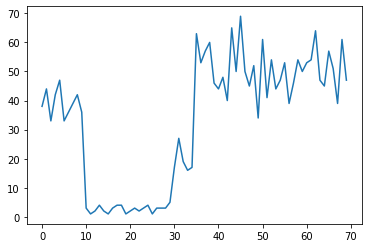

In [2]:
true_rates = [40, 3, 20, 50]
true_durations = [10, 20, 5, 35]

np.random.seed(42)

observed_counts = np.concatenate([
  scipy.stats.poisson(rate).rvs(num_steps)
    for (rate, num_steps) in zip(true_rates, true_durations)
]).astype(np.float32)

plt.plot(observed_counts)

# Model with fixed $K$

To model the changing Poisson rate, we use an HMM.
We initially assume the number of states is known to be $K=4$.
Later we will try comparing HMMs with different $K$.

We fix the initial state distribution to be uniform,
and fix the transition matrix to be the following, where we set $p=0.05$:

$$
\begin{align*}
z_1 &\sim \text{Categorical}\left(\left\{\frac{1}{4}, \frac{1}{4}, \frac{1}{4}, \frac{1}{4}\right\}\right)\\
z_t | z_{t-1} &\sim \text{Categorical}\left(\left\{\begin{array}{cc}p & \text{if } z_t = z_{t-1} \\ \frac{1-p}{4-1} & \text{otherwise}\end{array}\right\}\right)
\end{align*}$$


In [3]:
num_states = 4

initial_state_logits = np.zeros([num_states], dtype=np.float32) # uniform distribution

daily_change_prob = 0.05
transition_probs = daily_change_prob / (num_states-1) * np.ones(
    [num_states, num_states], dtype=np.float32)
np.fill_diagonal(transition_probs,
                 1-daily_change_prob)

print("Initial state logits:\n{}".format(initial_state_logits))
print("Transition matrix:\n{}".format(transition_probs))

Initial state logits:
[0. 0. 0. 0.]
Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


Now we create an HMM where the observation distribution is a Poisson with learnable parameters. We specify the parameters in log space and initialize them to random values around the log of the overall mean count (to set the scale).

In [4]:
# Define variable to represent the unknown log rates.

np.random.seed(1)

trainable_log_rates = tf.Variable(
  np.log(np.mean(observed_counts)) + tf.random.normal([num_states]),
  name='log_rates')

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=initial_state_logits),
  transition_distribution=tfd.Categorical(probs=transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))

# Model fitting using gradient descent.

We compute a MAP estimate of the Poisson rates $\lambda$ using batch gradient descent, using the Adam optimizer applied to the log likelihood (from the HMM) plus the log prior for $p(\lambda)$.

Inferred rates: [50.922253  2.666758 19.002943 38.918983]
True rates: [40, 3, 20, 50]


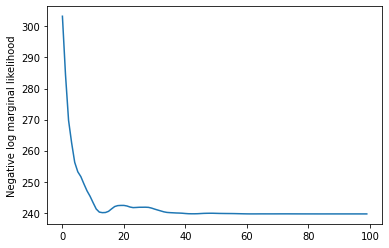

In [5]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
 return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) +
         hmm.log_prob(observed_counts))

losses = tfp.math.minimize(
    lambda: -log_prob(),
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=100)
plt.plot(losses)
plt.ylabel('Negative log marginal likelihood')

rates = tf.exp(trainable_log_rates)
print("Inferred rates: {}".format(rates))
print("True rates: {}".format(true_rates))

We see that the method learned a good approximation to the true (generating) parameters, up to a permutation of the states (since the labels are unidentifiable). However, results can vary with different random seeds. We may find that   the rates are the same for some states, which means those states are  being treated as identical, and are therefore redundant.

# Plotting the posterior  over states

In [6]:
# Runs forward-backward algorithm to compute marginal posteriors.
posterior_dists = hmm.posterior_marginals(observed_counts)
posterior_probs = posterior_dists.probs_parameter().numpy()

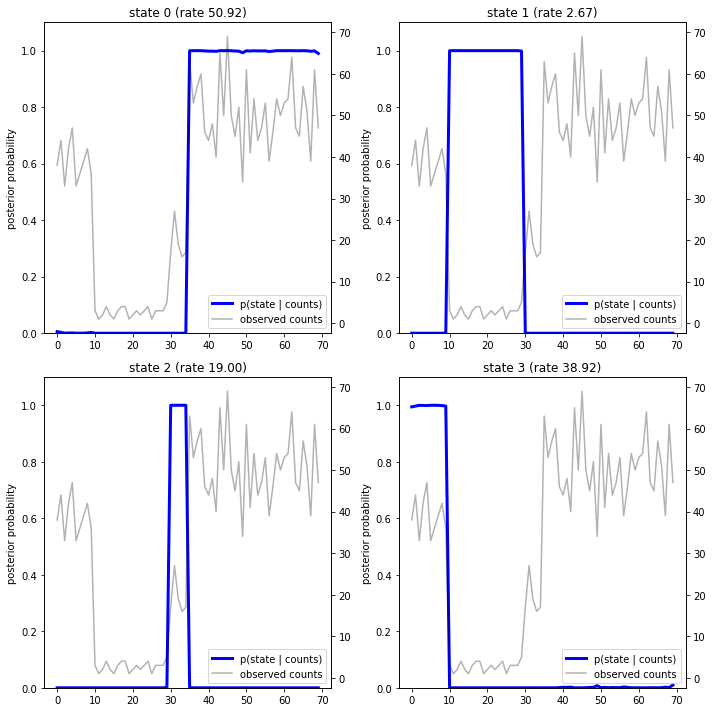

In [7]:
def plot_state_posterior(ax, state_posterior_probs, title):
  ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state | counts)')
  ax.set_ylim(0., 1.1)
  ax.set_ylabel('posterior probability')
  ax2 = ax.twinx()
  ln2 = ax2.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax2.set_title(title)
  ax2.set_xlabel("time")
  lns = ln1+ln2
  labs = [l.get_label() for l in lns]
  ax.legend(lns, labs, loc=4)
  ax.grid(True, color='white')
  ax2.grid(False)

fig = plt.figure(figsize=(10, 10))
plot_state_posterior(fig.add_subplot(2, 2, 1),
                     posterior_probs[:, 0],
                     title="state 0 (rate {:.2f})".format(rates[0]))
plot_state_posterior(fig.add_subplot(2, 2, 2),
                     posterior_probs[:, 1],
                     title="state 1 (rate {:.2f})".format(rates[1]))
plot_state_posterior(fig.add_subplot(2, 2, 3),
                     posterior_probs[:, 2],
                     title="state 2 (rate {:.2f})".format(rates[2]))
plot_state_posterior(fig.add_subplot(2, 2, 4),
                     posterior_probs[:, 3],
                     title="state 3 (rate {:.2f})".format(rates[3]))
plt.tight_layout()

In [10]:
print(rates)
rates_np = rates.numpy()
print(rates_np)

tf.Tensor([50.922253  2.666758 19.002943 38.918983], shape=(4,), dtype=float32)
[50.922253  2.666758 19.002943 38.918983]


In [11]:
# max marginals
most_probable_states = np.argmax(posterior_probs, axis=1)

most_probable_rates = rates_np[most_probable_states]

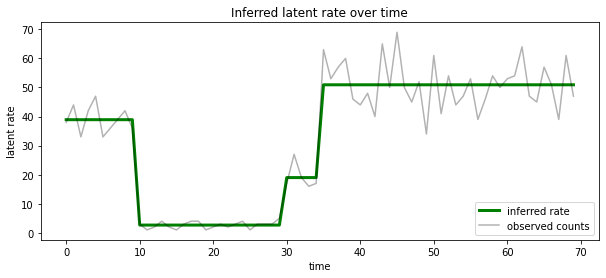

In [12]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")
ax.legend(loc=4)

In [13]:
# max probaility trajectory (Viterbi)
most_probable_states = hmm.posterior_mode(observed_counts)
most_probable_rates = rates_np[most_probable_states]

Text(0.5, 1.0, 'Inferred latent rate over time')

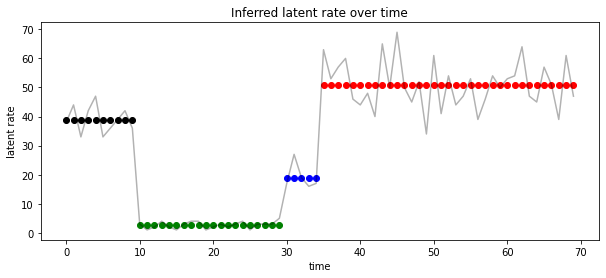

In [14]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
color_list = np.array(['r', 'g', 'b', 'k'])
colors = color_list[most_probable_states]
for i in range(len(colors)):
  ax.plot(i, most_probable_rates[i], '-o', c=colors[i], lw=3)
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")

# Model with unknown $K$

In general we don't know the true number of states. One way to select the 'best' model is to compute the one with the maximum marginal likelihood. Rather than summing over both discrete latent states and integrating over the unknown parameters $\lambda$, we just maximuze over the parameters (empirical Bayes approximation).

$$p(x_{1:T}|K) \approx \max_\lambda \int p(x_{1:T}, z_{1:T} | \lambda, K) dz$$


We can do this by fitting a bank of separate HMMs in parallel, one for each value of $K$. We need to make them all the same size so we can batch them efficiently. To do this, we pad the transition matrices (and other paraemeter vectors) so they all have the same shape, and then use masking.

In [15]:
max_num_states = 6

def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):

  # Give probability exp(-100) ~= 0 to states outside of the current model.
  initial_state_logits = -100. * np.ones([max_num_states], dtype=np.float32)
  initial_state_logits[:num_states] = 0.

  # Build a transition matrix that transitions only within the current
  # `num_states` states.
  transition_probs = np.eye(max_num_states, dtype=np.float32)
  if num_states > 1:
    transition_probs[:num_states, :num_states] = (
        daily_change_prob / (num_states-1))
    np.fill_diagonal(transition_probs[:num_states, :num_states],
                     1-daily_change_prob)
  return initial_state_logits, transition_probs

# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_logits = []
batch_transition_probs = []
for num_states in range(1, max_num_states+1):
  initial_state_logits, transition_probs = build_latent_state(
      num_states=num_states,
      max_num_states=max_num_states)
  batch_initial_state_logits.append(initial_state_logits)
  batch_transition_probs.append(transition_probs)

batch_initial_state_logits = np.array(batch_initial_state_logits)
batch_transition_probs = np.array(batch_transition_probs)
print("Shape of initial_state_logits: {}".format(batch_initial_state_logits.shape))
print("Shape of transition probs: {}".format(batch_transition_probs.shape))
print("Example initial state logits for num_states==3:\n{}".format(batch_initial_state_logits[2, :]))
print("Example transition_probs for num_states==3:\n{}".format(batch_transition_probs[2, :, :]))

Shape of initial_state_logits: (6, 6)
Shape of transition probs: (6, 6, 6)
Example initial state logits for num_states==3:
[   0.    0.    0. -100. -100. -100.]
Example transition_probs for num_states==3:
[[0.95  0.025 0.025 0.    0.    0.   ]
 [0.025 0.95  0.025 0.    0.    0.   ]
 [0.025 0.025 0.95  0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    1.   ]]


In [16]:
trainable_log_rates = tf.Variable(
    tf.fill([batch_initial_state_logits.shape[0], max_num_states],
            tf.math.log(tf.reduce_mean(observed_counts))) + 
     tf.random.stateless_normal([1, max_num_states], seed=(42, 42)),
     name='log_rates')
    
hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=batch_initial_state_logits),
  transition_distribution=tfd.Categorical(probs=batch_transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))
print("Defined HMM with batch shape: {}".format(hmm.batch_shape))

Defined HMM with batch shape: (6,)


In [17]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
  prior_lps = rate_prior.log_prob(tf.math.exp(trainable_log_rates))
  prior_lp = tf.stack(
      [tf.reduce_sum(prior_lps[i, :i+1]) for i in range(max_num_states)])
  return prior_lp + hmm.log_prob(observed_counts)

# Model fitting with gradient descent

Text(0, 0.5, 'Negative log marginal likelihood')

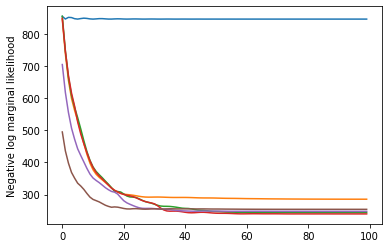

In [18]:
losses = tfp.math.minimize(
    lambda: -log_prob(),
    optimizer=tf.optimizers.Adam(0.1),
    num_steps=100)
plt.plot(losses)
plt.ylabel('Negative log marginal likelihood')

# Plot marginal likelihood of each model

Text(0.5, 1.0, 'Model selection on latent states')

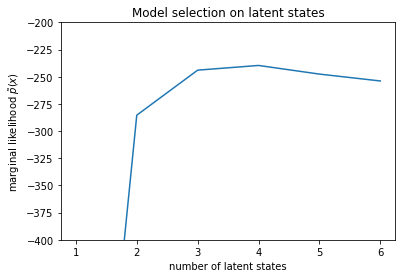

In [20]:
num_states = np.arange(1, max_num_states+1)
plt.plot(num_states, -losses[-1])
plt.ylim([-400, -200])
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states")

# Plot posteriors

In [24]:
rates = tf.exp(trainable_log_rates).numpy()
for i, learned_model_rates in enumerate(rates):
  print("rates for {}-state model: {}".format(i+1, learned_model_rates[:i+1]))

rates for 1-state model: [33.18287]
rates for 2-state model: [ 2.7545326 45.355827 ]
rates for 3-state model: [ 2.6430626 19.136448  48.350582 ]
rates for 4-state model: [ 2.636782 50.90375  38.697502 19.261536]
rates for 5-state model: [19.125282  76.214874  38.890526  50.876938   2.6208572]
rates for 6-state model: [38.809532  78.43149   38.876434  50.88929   19.020943   2.6848748]


In [25]:
posterior_probs = hmm.posterior_marginals(
    observed_counts).probs_parameter().numpy()
most_probable_states = np.argmax(posterior_probs, axis=-1)

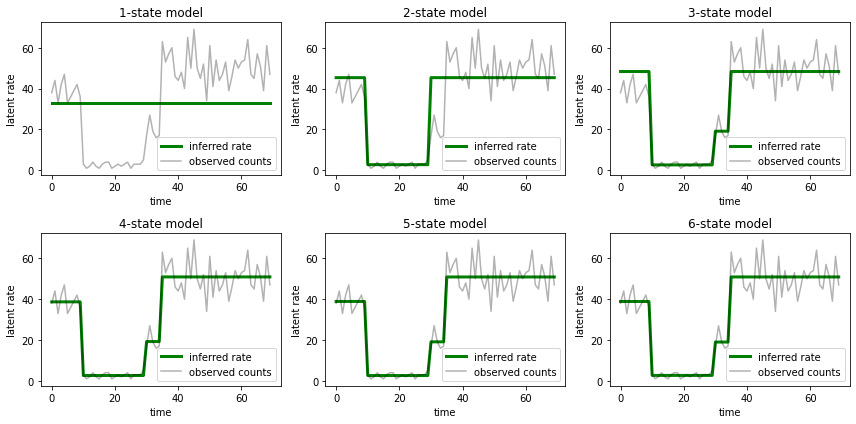

In [26]:
fig = plt.figure(figsize=(12, 6))
for i, learned_model_rates in enumerate(rates):
  ax = fig.add_subplot(2, 3, i+1)
  ax.plot(learned_model_rates[most_probable_states[i]], c='green', lw=3, label='inferred rate')
  ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax.set_ylabel("latent rate")
  ax.set_xlabel("time")
  ax.set_title("{}-state model".format(i+1))
  ax.legend(loc=4)
plt.tight_layout()